# MeiTou Custom Metrics Demo 
This notebook demonstrates how to fetch financial and economic metrics
for retail demand forecasting.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

# Add src to path to import our package
sys.path.insert(0, '../../')

from finance_metrics import * # MarketIndices, CommodityPrices, MacroIndicators, ConsumerMetrics, CustomMetrics

In [2]:
START_DATE = '2023-01-01'
END_DATE = '2025-12-01'

## Custom Metrics - MeiTou QQQ 200 Days Deviation Index

The MeiTou QQQ Deviation Index measures how far QQQ (Nasdaq-100 ETF) is trading from its 200-day moving average, providing insight into market momentum and potential turning points.

In [3]:
CUSTOM_START_DATE = "2015-01-01"

# Initialize CustomMetrics
custom = CustomMetrics()

# Calculate MeiTou QQQ Deviation Index
# Note: Need data before start date for 200-day SMA calculation
qqq_deviation = custom.get_meitou_qqq_deviation(
    start_date=CUSTOM_START_DATE,  # Extra data for SMA warmup
    end_date=END_DATE
)

print("MeiTou QQQ 200 Days Deviation Index:")
display(qqq_deviation.tail(10))

# Show current status
current_dev = qqq_deviation['Deviation'].iloc[-1]
current_signal = qqq_deviation['Signal'].iloc[-1]
print(f"\nCurrent Deviation: {current_dev:.2%}")
print(f"Current Signal: {current_signal}")

MeiTou QQQ 200 Days Deviation Index:


Price,Close,SMA_200,Deviation,Signal
Date,,,,
2025-11-14,608.859985,540.839059,0.125769,Strong Bullish
2025-11-17,603.659973,541.255739,0.115295,Strong Bullish
2025-11-18,596.309998,541.656491,0.100901,Strong Bullish
2025-11-19,599.869995,542.043362,0.106683,Strong Bullish
2025-11-20,585.669983,542.347377,0.079880,Strong Bullish
2025-11-21,590.070007,542.659695,0.087367,Strong Bullish
2025-11-24,605.159973,543.080736,0.114309,Strong Bullish
2025-11-25,608.890015,543.488897,0.120336,Strong Bullish
2025-11-26,614.270020,543.930235,0.129318,Strong Bullish



Current Deviation: 13.75%
Current Signal: Strong Bullish


### Normalized Version (0-100 Scale)

For easier interpretation and modeling, we can normalize the deviation to a 0-100 scale using historical data since 2015-01 as the calibration period.

In [4]:
# Get statistical summary
stats = custom.get_deviation_stats(start_date=CUSTOM_START_DATE, end_date=END_DATE)

print("Statistical Summary of QQQ Deviation Index:")
print(f"Mean Deviation: {stats['mean_deviation']:.2%}")
print(f"Median Deviation: {stats['median_deviation']:.2%}")
print(f"Std Deviation: {stats['std_deviation']:.2%}")
print(f"Min Deviation: {stats['min_deviation']:.2%}")
print(f"Max Deviation: {stats['max_deviation']:.2%}")
print(f"% Time Bullish: {stats['pct_bullish']:.1f}%")
print(f"% Time Bearish: {stats['pct_bearish']:.1f}%")

Statistical Summary of QQQ Deviation Index:


KeyError: 'mean_deviation'

In [ ]:
# Calculate normalized deviation (0-100 scale)
# Uses 1st and 99th percentiles from 2015-01 onwards as bounds
qqq_normalized = custom.get_meitou_qqq_deviation_normalized(
    start_date="2022-01-01",
    end_date=END_DATE,
    calibration_start="2015-01-01",  # Historical data for calibration
    use_percentiles=True,  # Use percentiles instead of raw min/max (more robust)
    lower_percentile=1.0,  # 1st percentile as lower bound
    upper_percentile=99.0   # 99th percentile as upper bound
)

print("Normalized MeiTou QQQ Deviation Index (0-100 scale):")
print("\nLast 10 days:")
display(qqq_normalized[['Close', 'SMA_200', 'Deviation', 'Deviation_Normalized', 'Signal']].tail(10))

# Show normalization statistics
current_norm = qqq_normalized['Deviation_Normalized'].iloc[-1]
mean_norm = qqq_normalized['Deviation_Normalized'].mean()
print(f"\nCurrent Normalized Value: {current_norm:.2f}/100")
print(f"Mean Normalized Value: {mean_norm:.2f}/100")
print(f"Current Signal: {qqq_normalized['Signal'].iloc[-1]}")

Normalized MeiTou QQQ Deviation Index (0-100 scale):

Last 10 days:


Price,Close,SMA_200,Deviation,Deviation_Normalized,Signal
Date,,,,,
2025-11-14,608.859985,540.839060,0.125769,73.049416,Strong Bullish
2025-11-17,603.659973,541.255740,0.115295,70.544843,Strong Bullish
2025-11-18,596.309998,541.656491,0.100901,67.102755,Bullish
2025-11-19,599.869995,542.043362,0.106683,68.485365,Bullish
2025-11-20,585.669983,542.347378,0.079880,62.076171,Bullish
2025-11-21,590.070007,542.659695,0.087367,63.866430,Bullish
2025-11-24,605.159973,543.080737,0.114309,70.309097,Strong Bullish
2025-11-25,608.890015,543.488897,0.120336,71.750126,Strong Bullish
2025-11-26,614.270020,543.930235,0.129318,73.897923,Strong Bullish



Current Normalized Value: 75.85/100
Mean Normalized Value: 63.68/100
Current Signal: Strong Bullish


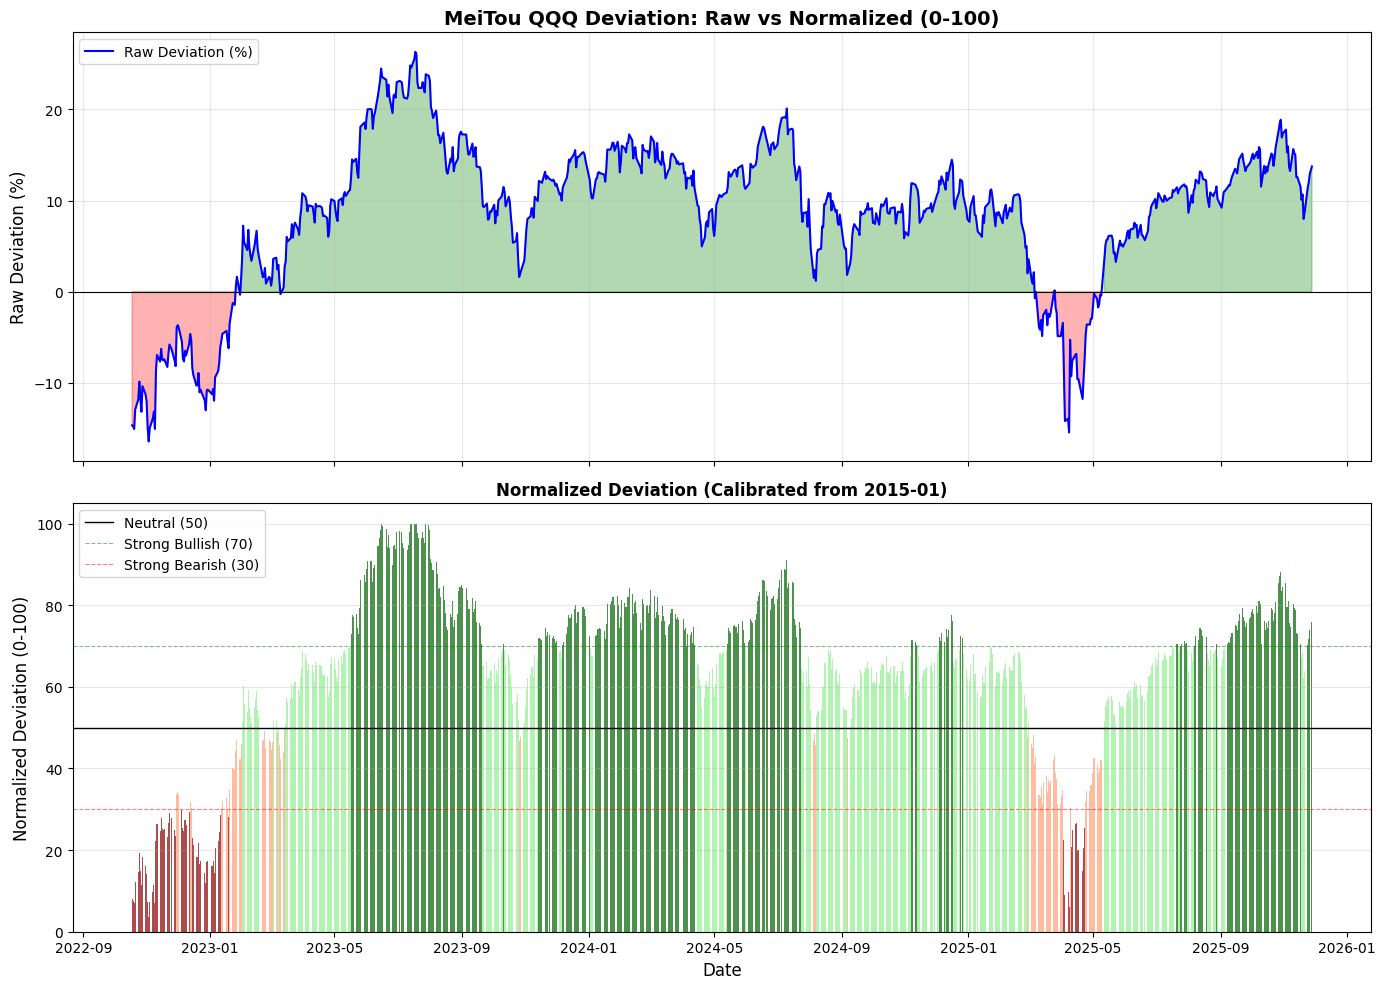


Interpretation:
  0-30: Strong Bearish (bottom 30% of historical range)
 30-50: Bearish/Neutral
 50-70: Bullish/Neutral
70-100: Strong Bullish (top 30% of historical range)


In [ ]:
# Visualize normalized deviation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Top panel: Raw deviation
ax1.plot(qqq_normalized.index, qqq_normalized['Deviation'] * 100, linewidth=1.5, color='blue', label='Raw Deviation (%)')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax1.fill_between(qqq_normalized.index, 0, qqq_normalized['Deviation'] * 100, 
                  where=(qqq_normalized['Deviation'] * 100 >= 0), alpha=0.3, color='green')
ax1.fill_between(qqq_normalized.index, 0, qqq_normalized['Deviation'] * 100, 
                  where=(qqq_normalized['Deviation'] * 100 < 0), alpha=0.3, color='red')
ax1.set_ylabel('Raw Deviation (%)', fontsize=12)
ax1.set_title('MeiTou QQQ Deviation: Raw vs Normalized (0-100)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Bottom panel: Normalized deviation (0-100)
colors = []
for val in qqq_normalized['Deviation_Normalized']:
    if val >= 70:
        colors.append('darkgreen')
    elif val >= 50:
        colors.append('lightgreen')
    elif val >= 30:
        colors.append('lightsalmon')
    else:
        colors.append('darkred')

ax2.bar(qqq_normalized.index, qqq_normalized['Deviation_Normalized'], color=colors, alpha=0.7, width=1)
ax2.axhline(y=50, color='black', linestyle='-', linewidth=1, label='Neutral (50)')
ax2.axhline(y=70, color='green', linestyle='--', linewidth=0.8, alpha=0.5, label='Strong Bullish (70)')
ax2.axhline(y=30, color='red', linestyle='--', linewidth=0.8, alpha=0.5, label='Strong Bearish (30)')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Normalized Deviation (0-100)', fontsize=12)
ax2.set_ylim(0, 105)
ax2.set_title('Normalized Deviation (Calibrated from 2015-01)', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nInterpretation:")
print(f"  0-30: Strong Bearish (bottom 30% of historical range)")
print(f" 30-50: Bearish/Neutral")
print(f" 50-70: Bullish/Neutral")
print(f"70-100: Strong Bullish (top 30% of historical range)")

In [ ]:
# If use normalized deviation instead
if True:
    qqq_deviation = qqq_normalized
    qqq_deviation['Deviation'] = qqq_deviation['Deviation_Normalized']/100

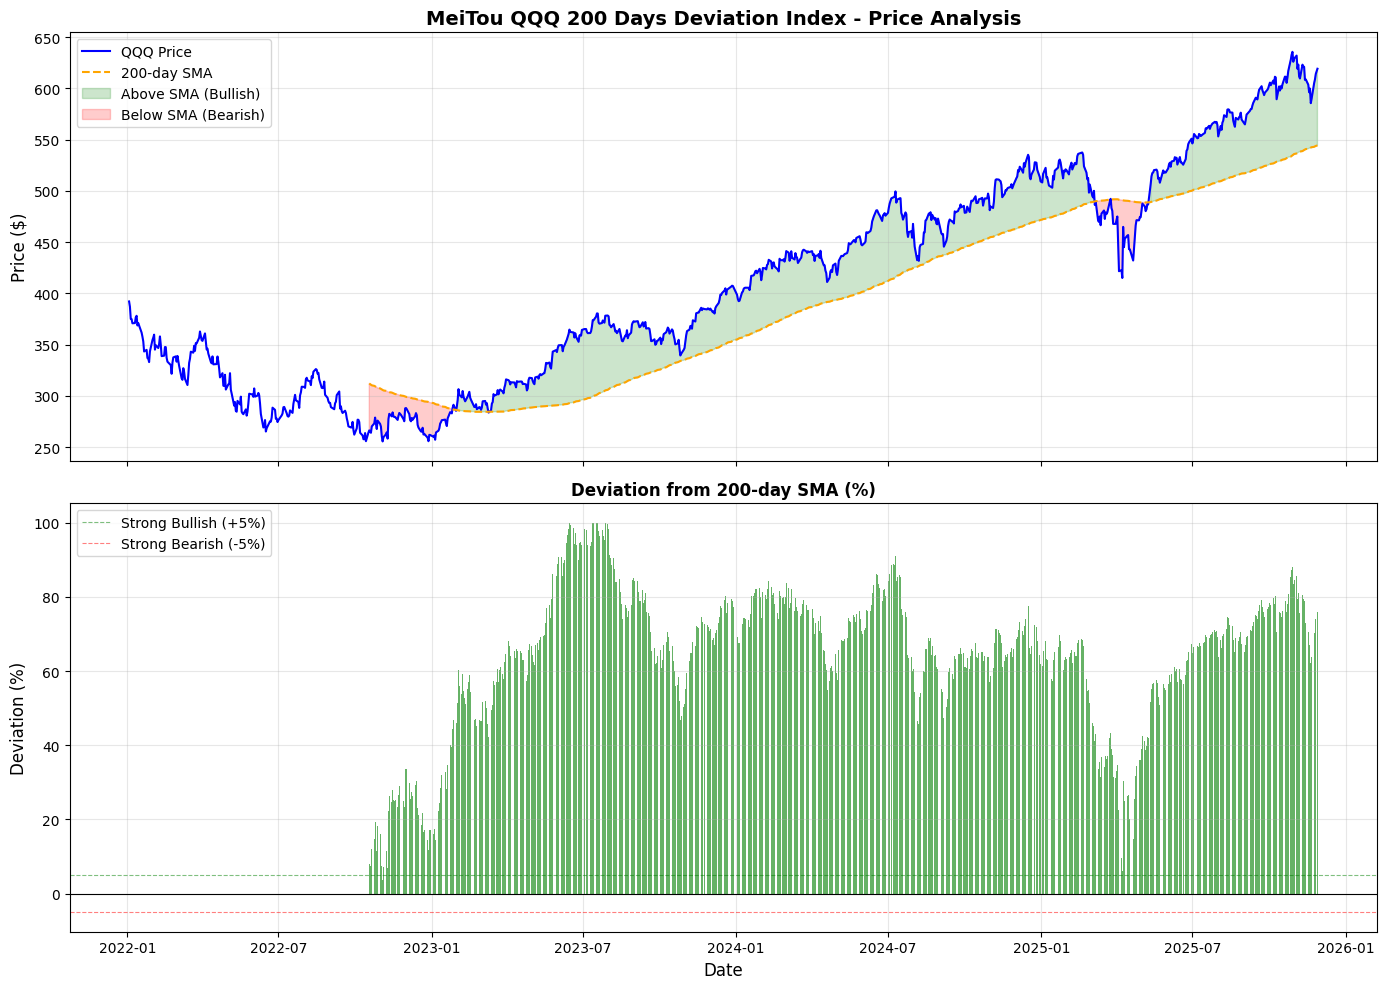


Current Status: QQQ is 13.75% ABOVE its 200-day SMA


In [ ]:
# Visualization 1: QQQ Price vs 200-day SMA
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Top panel: Price and SMA
ax1.plot(qqq_deviation.index, qqq_deviation['Close'], label='QQQ Price', linewidth=1.5, color='blue')
ax1.plot(qqq_deviation.index, qqq_deviation['SMA_200'], label='200-day SMA', linewidth=1.5, color='orange', linestyle='--')
ax1.fill_between(qqq_deviation.index, 
                  qqq_deviation['Close'], 
                  qqq_deviation['SMA_200'],
                  where=(qqq_deviation['Close'] >= qqq_deviation['SMA_200']),
                  alpha=0.2, color='green', label='Above SMA (Bullish)')
ax1.fill_between(qqq_deviation.index, 
                  qqq_deviation['Close'], 
                  qqq_deviation['SMA_200'],
                  where=(qqq_deviation['Close'] < qqq_deviation['SMA_200']),
                  alpha=0.2, color='red', label='Below SMA (Bearish)')
ax1.set_ylabel('Price ($)', fontsize=12)
ax1.set_title('MeiTou QQQ 200 Days Deviation Index - Price Analysis', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Bottom panel: Deviation percentage
colors = ['green' if x > 0 else 'red' for x in qqq_deviation['Deviation']]
ax2.bar(qqq_deviation.index, qqq_deviation['Deviation'] * 100, color=colors, alpha=0.6, width=1)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.axhline(y=5, color='green', linestyle='--', linewidth=0.8, alpha=0.5, label='Strong Bullish (+5%)')
ax2.axhline(y=-5, color='red', linestyle='--', linewidth=0.8, alpha=0.5, label='Strong Bearish (-5%)')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Deviation (%)', fontsize=12)
ax2.set_title('Deviation from 200-day SMA (%)', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCurrent Status: QQQ is {abs(current_dev):.2%} {'ABOVE' if current_dev > 0 else 'BELOW'} its 200-day SMA")

/var/folders/x4/dyk31hkd1850s3dyrqpd48100000gn/T/ipykernel_94134/3721228028.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(signal_data, labels=signal_labels)


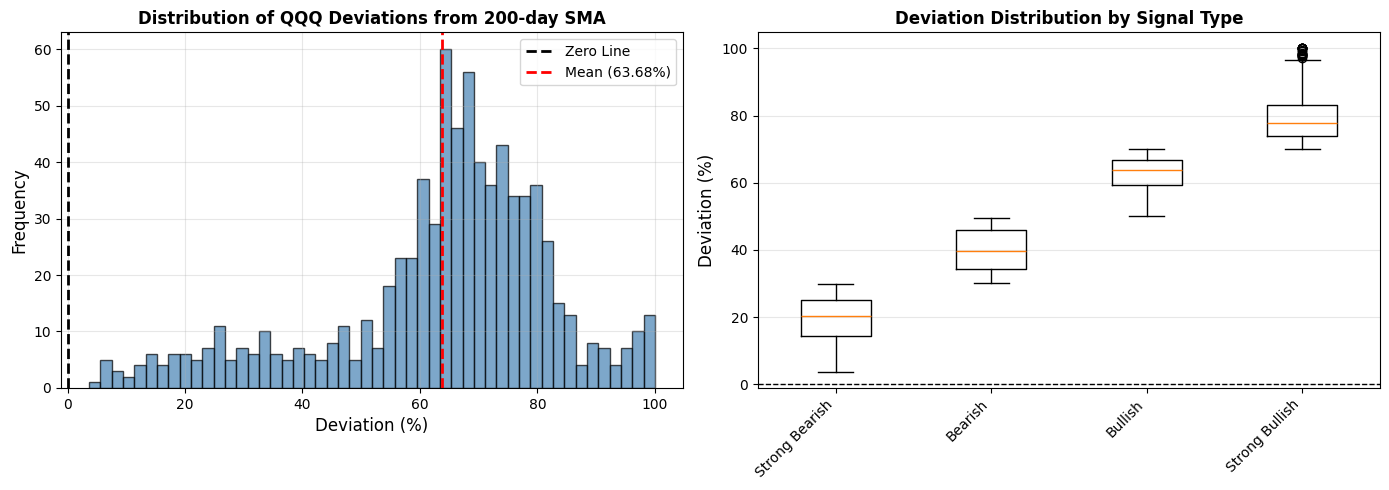

In [ ]:
# Visualization 2: Distribution of Deviations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
valid_deviations = qqq_deviation['Deviation'].dropna() * 100
ax1.hist(valid_deviations, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Zero Line')
ax1.axvline(x=valid_deviations.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean ({valid_deviations.mean():.2f}%)')
ax1.set_xlabel('Deviation (%)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of QQQ Deviations from 200-day SMA', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Box plot by signal type
signal_data = []
signal_labels = []
for signal in ['Strong Bearish', 'Bearish', 'Bullish', 'Strong Bullish']:
    mask = qqq_deviation['Signal'] == signal
    if mask.sum() > 0:
        signal_data.append(qqq_deviation.loc[mask, 'Deviation'].dropna() * 100)
        signal_labels.append(signal)

ax2.boxplot(signal_data, labels=signal_labels)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_ylabel('Deviation (%)', fontsize=12)
ax2.set_title('Deviation Distribution by Signal Type', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Interpretation of MeiTou QQQ Deviation Index

**Signal Meanings:**
- **Strong Bullish** (>+5%): QQQ is significantly above its 200-day trend → Strong positive momentum, possible overextension
- **Bullish** (0% to +5%): QQQ is moderately above trend → Positive momentum
- **Bearish** (-5% to 0%): QQQ is moderately below trend → Negative momentum
- **Strong Bearish** (<-5%): QQQ is significantly below its 200-day trend → Strong negative momentum, possible oversold

**Use for Retail Forecasting:**
- Tech sector momentum (Nasdaq-100) influences consumer confidence and spending
- Extreme deviations (±5% or more) may signal economic turning points
- Weekly deviation values can be used as a feature in demand forecasting models
- Correlate with retail categories (e.g., electronics, luxury goods) sensitive to market sentiment

---
## Custom Metrics - MeiTou Put/Call Ratio

The Put/Call Ratio measures the ratio of put option volume to call option volume. It's a **contrarian indicator** for market sentiment.

**Interpretation:**
- **High ratio (>1.0)**: Bearish sentiment → Potentially bullish signal (oversold)
- **Low ratio (<0.7)**: Bullish sentiment → Potentially bearish signal (overbought)
- **Around 0.7-0.9**: Neutral sentiment

Uses CBOE Equity Put/Call Ratio (^CPCE) by default.

In [5]:
# Calculate Put/Call Ratio
pcr = custom.get_put_call_ratio(start_date=START_DATE, end_date=END_DATE)

print("Put/Call Ratio (Last 10 days):")
display(pcr.tail(10))

# Show current status
current_pcr = pcr['PutCallRatio'].iloc[-1]
current_signal = pcr['Signal'].iloc[-1]
print(f"\nCurrent Put/Call Ratio: {current_pcr:.4f}")
print(f"Current Signal: {current_signal}")

HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: ^CPCE"}}}

1 Failed download:
['^CPCE']: YFTzMissingError('possibly delisted; no timezone found')


Put/Call Ratio (Last 10 days):


,PutCallRatio,Signal
Date,,


IndexError: single positional indexer is out-of-bounds

In [1]:
import pandas as pd
import requests

# AlphaQuery stores the CBOE Total P/C Ratio in a viewable table
# You might need to spoof the User-Agent to avoid being blocked
url = "https://www.alphaquery.com/stock/US-Market/volatility-option-statistics/120-day/put-call-ratio-volume"
headers = {'User-Agent': 'Mozilla/5.0'}

try:
    # Use pandas to extract tables directly from the HTML
    dfs = pd.read_html(requests.get(url, headers=headers).text)
    
    # Usually the relevant data is in the first or second table
    df_ratio = dfs[0] 
    print(df_ratio.head())
    
    # Now you have the 120-day history for free
except Exception as e:
    print(f"Scraping failed: {e}")

Scraping failed: No tables found


/var/folders/x4/dyk31hkd1850s3dyrqpd48100000gn/T/ipykernel_43586/2717231087.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dfs = pd.read_html(requests.get(url, headers=headers).text)


In [ ]:
# Statistical Summary
pcr_stats = custom.get_put_call_ratio_stats(start_date=START_DATE, end_date=END_DATE)

print("Put/Call Ratio - Statistical Summary:")
print(f"Mean: {pcr_stats['mean']:.4f}")
print(f"Median: {pcr_stats['median']:.4f}")
print(f"Std Dev: {pcr_stats['std']:.4f}")
print(f"Min: {pcr_stats['min']:.4f}")
print(f"Max: {pcr_stats['max']:.4f}")
print(f"Current: {pcr_stats['current']:.4f}")
print(f"\nSentiment Analysis (Contrarian):")
print(f"Bullish Signal (>0.9): {pcr_stats['pct_bullish_signal']:.1f}%")
print(f"Bearish Signal (<0.7): {pcr_stats['pct_bearish_signal']:.1f}%")
print(f"Neutral (0.7-0.9): {pcr_stats['pct_neutral']:.1f}%")

In [ ]:
# Visualization 1: Put/Call Ratio with Signal Zones
fig, ax = plt.subplots(figsize=(14, 6))

# Plot ratio
ax.plot(pcr.index, pcr['PutCallRatio'], linewidth=2, color='navy', label='Put/Call Ratio')

# Add signal zones
ax.axhline(y=1.2, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='Strong Bullish (>1.2)')
ax.axhline(y=0.9, color='lightgreen', linestyle='--', linewidth=1, alpha=0.7, label='Bullish (>0.9)')
ax.axhline(y=0.7, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='Bearish (<0.7)')
ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Strong Bearish (<0.5)')

# Shade zones
pcr_max = pcr['PutCallRatio'].max() if pcr['PutCallRatio'].max() > 1.2 else 1.5
pcr_min = pcr['PutCallRatio'].min() if pcr['PutCallRatio'].min() < 0.5 else 0.3
ax.axhspan(1.2, pcr_max, alpha=0.1, color='green')
ax.axhspan(0.9, 1.2, alpha=0.1, color='lightgreen')
ax.axhspan(0.5, 0.7, alpha=0.1, color='orange')
ax.axhspan(pcr_min, 0.5, alpha=0.1, color='red')

ax.set_ylabel('Put/Call Ratio', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_title('CBOE Equity Put/Call Ratio - Contrarian Sentiment Indicator', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation (Contrarian):")
print("  High ratio (>1.0) = Bearish sentiment → Bullish signal (fear/oversold)")
print("  Low ratio (<0.7) = Bullish sentiment → Bearish signal (greed/overbought)")

### Normalized Put/Call Ratio (0-100 Scale)

For easier interpretation and modeling, we normalize the Put/Call Ratio to a 0-100 scale using historical data since 2015-01 as the calibration period.

In [ ]:
# Calculate normalized Put/Call Ratio (0-100 scale)
pcr_normalized = custom.get_put_call_ratio_normalized(
    start_date=START_DATE,
    end_date=END_DATE,
    calibration_start="2015-01-01",  # Historical data for calibration
    use_percentiles=True,
    lower_percentile=1.0,
    upper_percentile=99.0
)

print("Normalized Put/Call Ratio (Last 10 days):")
display(pcr_normalized[['PutCallRatio', 'PutCallRatio_Normalized', 'Signal']].tail(10))

# Show normalization statistics
current_norm = pcr_normalized['PutCallRatio_Normalized'].iloc[-1]
mean_norm = pcr_normalized['PutCallRatio_Normalized'].mean()
print(f"\nCurrent Normalized Value: {current_norm:.2f}/100")
print(f"Mean Normalized Value: {mean_norm:.2f}/100")
print(f"Current Signal: {pcr_normalized['Signal'].iloc[-1]}")

In [ ]:
# Visualization 2: Raw vs Normalized Put/Call Ratio
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Top panel: Raw Ratio
ax1.plot(pcr_normalized.index, pcr_normalized['PutCallRatio'], linewidth=2, color='navy')
ax1.axhline(y=0.7, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='Bearish threshold (0.7)')
ax1.axhline(y=0.9, color='green', linestyle='--', linewidth=1, alpha=0.7, label='Bullish threshold (0.9)')
ax1.fill_between(pcr_normalized.index, 0.9, pcr_normalized['PutCallRatio'],
                  where=(pcr_normalized['PutCallRatio'] >= 0.9), alpha=0.2, color='green')
ax1.fill_between(pcr_normalized.index, 0.7, pcr_normalized['PutCallRatio'],
                  where=(pcr_normalized['PutCallRatio'] <= 0.7), alpha=0.2, color='red')
ax1.set_ylabel('Raw Ratio', fontsize=12)
ax1.set_title('Put/Call Ratio: Raw vs Normalized', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Bottom panel: Normalized Ratio (0-100)
colors = []
for val in pcr_normalized['PutCallRatio_Normalized']:
    if val >= 70:
        colors.append('darkgreen')
    elif val >= 60:
        colors.append('lightgreen')
    elif val >= 40:
        colors.append('gray')
    elif val >= 30:
        colors.append('lightsalmon')
    else:
        colors.append('darkred')

ax2.bar(pcr_normalized.index, pcr_normalized['PutCallRatio_Normalized'], 
        color=colors, alpha=0.7, width=1)
ax2.axhline(y=50, color='black', linestyle='-', linewidth=1, label='Neutral (50)')
ax2.axhline(y=70, color='green', linestyle='--', linewidth=1, alpha=0.7, label='Strong Bullish (70)')
ax2.axhline(y=60, color='lightgreen', linestyle='--', linewidth=0.8, alpha=0.5, label='Bullish (60)')
ax2.axhline(y=40, color='orange', linestyle='--', linewidth=0.8, alpha=0.5, label='Bearish (40)')
ax2.axhline(y=30, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Strong Bearish (30)')
ax2.set_ylabel('Normalized (0-100)', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylim(0, 105)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nNormalized Scale Interpretation (Contrarian):")
print("  0-30: Strong Bearish (excessive optimism → overbought)")
print(" 30-40: Bearish")
print(" 40-60: Neutral")
print(" 60-70: Bullish")
print("70-100: Strong Bullish (excessive pessimism → oversold)")

In [ ]:
# Weekly Aggregation
pcr_weekly = custom.get_put_call_ratio_weekly(start_date=START_DATE, end_date=END_DATE)

print("Weekly Put/Call Ratio (Last 10 weeks):")
display(pcr_weekly.tail(10))

# Visualization: Weekly Put/Call Ratio
fig, ax = plt.subplots(figsize=(14, 6))

# Bar chart for weekly data
colors = ['green' if x > 0.9 else 'red' if x < 0.7 else 'gray' for x in pcr_weekly['PutCallRatio']]
ax.bar(pcr_weekly.index, pcr_weekly['PutCallRatio'], color=colors, alpha=0.6, width=6, edgecolor='black')

# Add threshold lines
ax.axhline(y=0.9, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='Bullish (>0.9)')
ax.axhline(y=0.7, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Bearish (<0.7)')

ax.set_ylabel('Weekly Avg Put/Call Ratio', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_title('Weekly Put/Call Ratio - Sentiment Signals', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---
## Comparison: QQQ Deviation vs Put/Call Ratio

Comparing both metrics to understand how market sentiment aligns with price trends.

In [ ]:
# Comparison visualization - need to align dates
# Get both normalized metrics for the same period
comparison_start = "2023-01-01"
qqq_comp = custom.get_meitou_qqq_deviation_normalized(comparison_start, END_DATE)
pcr_comp = custom.get_put_call_ratio_normalized(comparison_start, END_DATE)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Top panel: QQQ Deviation (Normalized)
ax1.plot(qqq_comp.index, qqq_comp['Deviation_Normalized'], linewidth=2, color='blue', label='QQQ Deviation')
ax1.axhline(y=50, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax1.fill_between(qqq_comp.index, 50, qqq_comp['Deviation_Normalized'], 
                  where=(qqq_comp['Deviation_Normalized'] > 50), alpha=0.3, color='green', label='Above 200-day SMA')
ax1.fill_between(qqq_comp.index, 50, qqq_comp['Deviation_Normalized'], 
                  where=(qqq_comp['Deviation_Normalized'] <= 50), alpha=0.3, color='red', label='Below 200-day SMA')
ax1.set_ylabel('QQQ Deviation\\n(Normalized 0-100)', fontsize=12)
ax1.set_title('Market Trend vs Sentiment: QQQ Deviation and Put/Call Ratio', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 100)

# Bottom panel: Put/Call Ratio (Normalized)
ax2.plot(pcr_comp.index, pcr_comp['PutCallRatio_Normalized'], linewidth=2, color='purple', label='Put/Call Ratio')
ax2.axhline(y=50, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax2.fill_between(pcr_comp.index, 50, pcr_comp['PutCallRatio_Normalized'], 
                  where=(pcr_comp['PutCallRatio_Normalized'] > 50), alpha=0.3, color='green', 
                  label='Bearish Sentiment (Contrarian Bullish)')
ax2.fill_between(pcr_comp.index, 50, pcr_comp['PutCallRatio_Normalized'], 
                  where=(pcr_comp['PutCallRatio_Normalized'] <= 50), alpha=0.3, color='red', 
                  label='Bullish Sentiment (Contrarian Bearish)')
ax2.set_ylabel('Put/Call Ratio\\n(Normalized 0-100)', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("- QQQ Deviation: Direct trend indicator (high = bullish, low = bearish)")
print("- Put/Call Ratio: Contrarian sentiment (high = bullish signal, low = bearish signal)")
print("- Divergences between the two can signal potential trend changes")